## Importing Libraries

In [10]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score
%matplotlib inline
from math import asin
from datetime import datetime, timedelta
import swisseph as swe
from keras.models import Sequential
from keras.layers import Dense, Activation,LSTM,Dropout,LeakyReLU,Input,TimeDistributed,GRU
from keras.layers.wrappers import Bidirectional
from keras.optimizers import Adam
import keras
from tqdm import tqdm_notebook,tqdm,trange
import math
from copy import deepcopy


# Using FXCM to get more data

In [11]:
import fxcmpy
import datetime as dt
fxcmpy.__version__

'1.1.34'

In [12]:
TOKEN = ""

In [13]:
con=fxcmpy.fxcmpy(access_token=TOKEN,log_level='error')

In [14]:
type(con)

fxcmpy.fxcmpy.fxcmpy

In [17]:
con=fxcmpy.fxcmpy(config_file='fxcm.cfg',server='demo')

In [18]:
fxcm_close=con.get_candles('EUR/USD',period='D1',number=10000)

In [19]:
fxcm_close.shape

(4957, 9)

In [20]:
fxcm_close.reset_index(inplace=True)
fxcm_date = [date_time.to_pydatetime() for date_time in fxcm_close["date"]] 

In [21]:
fxcm_close.drop(['date','tickqty','askopen','askclose','askhigh','asklow','bidlow','bidopen','bidhigh'], axis=1, inplace=True)

In [22]:
fxcm_close.columns = ['Close']

In [23]:
fxcm_close = fxcm_close[4921:]
fxcm_date = fxcm_date[4921:]

## Reading Datasets and calculating Coordinates

In [24]:
eur=pd.read_csv('EURUSD.csv',parse_dates=['Date'])
#Change name of dataset, whichever dataset you wanna use


In [25]:
dates = [date_time.to_pydatetime() for date_time in eur["Date"]] 
#this are the dates that we'll use for calculating coordinates
eur['Year']=eur['Date'].map(lambda x:x.year)
eur['Month']=eur['Date'].map(lambda x:x.month)
date_eur = eur['Date'].map(lambda x:x.day)


## Change date as you want

In [26]:
from dateutil import rrule, parser
# date1 = '2018-12-01'
# date2 = '2019-1-28'
date2 = '2019-12-28'
date1 = '2019-01-28'
datesx = list(rrule.rrule(rrule.DAILY, dtstart=parser.parse(date1), until=parser.parse(date2)))

## The function for calculating coordinates

In [27]:
'''Just put dates in the function, in the format(to_pydatetime, function will take care of the rest'''#planet order for columns in csv
# p = '2314567'    
EARTH_RADIUS=6378136.6
AUNIT=1.49597870691e+11       #au in meters, AA 2006 K6
DEGTORAD=0.0174532925199433

planet_idx = {
                
            
                "Mercury" : 2,
                "Venus"   : 3,
                "Moon"    : 1,
                "Mars"    : 4,
                "Jupiter" : 5,
                "Saturn"  : 6,
                "Uranus"  : 7, 
                "Neptune" : 8,
                "Earth"   : 14,
            
            }
               
    
def calc_utc_coord(dates, input_planets_data):
#FLG_HELCTR works awesome so far
    def _swisseph(t, ipl):
        t = t[0]
        jd = swe.julday(t.year,t.month,t.day,t.hour+int(t.minute/60))
        rslt = swe.calc_ut(jd, ipl , swe.FLG_HELCTR | swe.FLG_EQUATORIAL | swe.FLG_SPEED)

        if ipl == 1: #Moon
            rm = swe.calc_ut(jd, ipl , swe.FLG_EQUATORIAL | swe.FLG_SPEED |swe.FLG_TRUEPOS | swe.FLG_RADIANS)
            sinhp = EARTH_RADIUS / rm[2] / AUNIT
            moondist=asin(sinhp) / DEGTORAD *3600
            return rslt[0], rslt[1], moondist

        return rslt[0], rslt[1], rslt[2]

    column_names = ['Dat']

    column_names.extend([x for x in planet_idx if x in input_planets_data])

   

    extended_dates = dates.copy()

    final_df = pd.DataFrame(index=extended_dates)
    extended_dates = np.vstack(np.asarray(extended_dates))

    for planet in column_names[1:]:

        result = np.apply_along_axis( _swisseph, 1, extended_dates, planet_idx[planet]) #Apply Swisseph func on every rows

        if "right asc." in input_planets_data[planet]:
            final_df.loc[:, planet+'_'+"right asc."] = result[:, 0] 

        if "declination" in input_planets_data[planet]:
            final_df.loc[:, planet+'_'+"declination"] = result[:, 1]

        if "distance" in input_planets_data[planet]:
            final_df.loc[:, planet+'_'+"distance"] = result[:, 2]

    return final_df.loc[dates, :]



planet_parameters = {
        "Mercury" : ["right asc.", "declination", "distance"],
        "Venus"   : ["right asc.", "declination", "distance"],
        "Moon"    : ["right asc.", "declination", "distance"],
        "Mars"    : ["right asc.", "declination", "distance"],
        "Jupiter" : ["right asc.", "declination", "distance"],
        "Saturn"  : ["right asc.", "declination", "distance"],
        "Uranus"  : ["right asc.", "declination", "distance"],
        "Earth"   : ["right asc.", "declination", "distance"],
        "Neptune" : ["right asc.", "declination", "distance"]
}



result=pd.DataFrame(calc_utc_coord(dates, planet_parameters))
myresult=pd.DataFrame(calc_utc_coord(datesx, planet_parameters))
fxcm_result = pd.DataFrame(calc_utc_coord(fxcm_date, planet_parameters))



In [28]:
result.reset_index(inplace=True)
myresult.reset_index(inplace=True)
fxcm_result.reset_index(inplace = True)

In [29]:
myresult['Year']=myresult['index'].map(lambda x:x.year)
myresult['Month']=myresult['index'].map(lambda x:x.month)
myresult_date = myresult['index'].map(lambda x:x.day)
myresult.drop(['index'],axis=1,inplace=True)


fxcm_result['Year']=fxcm_result['index'].map(lambda x:x.year)
fxcm_result['Month']=fxcm_result['index'].map(lambda x:x.month)
date_fxc = fxcm_result['index'].map(lambda x:x.day)
fxcm_result.drop(['index'],axis=1,inplace=True)



In [30]:
final_data=pd.concat([eur,result],axis=1)
final_data.head()

Date    Open    High     Low   Close  Year  Month      index  \
0 1993-05-11  1.2412  1.2412  1.2376  1.2376  1993      5 1993-05-11   
1 1993-05-12  1.2376  1.2376  1.2353  1.2353  1993      5 1993-05-12   
2 1993-05-13  1.2353  1.2353  1.2225  1.2225  1993      5 1993-05-13   
3 1993-05-14  1.2225  1.2345  1.2225  1.2345  1993      5 1993-05-14   
4 1993-05-18  1.2264  1.2264  1.2203  1.2203  1993      5 1993-05-18   

   Moon_right asc.  Moon_declination       ...        Neptune_distance  \
0       228.009732        -17.852260       ...               30.185435   
1       229.003203        -18.108166       ...               30.185416   
2       229.992945        -18.357845       ...               30.185398   
3       230.978791        -18.601345       ...               30.185379   
4       234.886557        -19.515352       ...               30.185303   

   Mercury_right asc.  Mercury_declination  Mercury_distance  \
0           24.493528             7.251746          0.329208   
1           29.536421             9.830053          0.324801   
2           34.793083            12.397100          0.320790   
3           40.281602            14.918542          0.317227   
4           64.753350            23.705809          0.308336   

   Uranus_right asc.  Uranus_declination  Uranus_distance  Earth_right asc.  \
0         291.172082          -22.466113        19.594183        227.876087   
1         291.184193          -22.464615        19.594351        228.855142   
2         291.196292          -22.463119        19.594518        229.836648   
3         291.208379          -22.461622        19.594686        230.820603   
4         291.256672          -22.455598        19.595356        234.780751   

   Earth_declination  Earth_distance  
0         -17.826018        1.009988  
1         -18.081259        1.010220  
2         -18.331450        1.010450  
3         -18.576508        1.010676  
4         -19.503820        1.011546  

[5 rows x 35 columns]

In [31]:
final_data.drop(['Open','High','Low','index'],axis=1,inplace=True)

## Feature Engineering and Data Cleaning

## Now we're making features

In [32]:
features=final_data[['Month','Year',
       'Moon_right asc.', 'Moon_declination', 'Moon_distance',
       'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance',
       'Venus_right asc.', 'Venus_declination', 'Venus_distance',
       'Mars_right asc.', 'Mars_declination', 'Mars_distance',
       'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance',
       'Saturn_right asc.', 'Saturn_declination', 'Saturn_distance',
       'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance',
       'Neptune_right asc.', 'Neptune_declination', 'Neptune_distance',
       'Earth_right asc.', 'Earth_declination', 'Earth_distance']]

target=final_data[['Close']]

feat_csv=final_data[['Month','Year',
       'Moon_right asc.', 'Moon_declination', 'Moon_distance',
       'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance',
       'Venus_right asc.', 'Venus_declination', 'Venus_distance',
       'Mars_right asc.', 'Mars_declination', 'Mars_distance',
       'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance',
       'Saturn_right asc.', 'Saturn_declination', 'Saturn_distance',
       'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance',
       'Neptune_right asc.', 'Neptune_declination', 'Neptune_distance',
       'Earth_right asc.', 'Earth_declination', 'Earth_distance']]

In [33]:
features = pd.concat([features, fxcm_result], axis = 0)
features.reset_index(inplace=True)
features.drop(['index'],axis=1,inplace=True)
feature_date = pd.concat([date_eur, date_fxc], axis = 0)


target = pd.concat([target, fxcm_close], axis = 0)
target.reset_index(inplace=True)
target.drop(['index'],axis=1,inplace=True)


features_csv = pd.concat([feat_csv, fxcm_result], axis = 0)
features_csv.reset_index(inplace=True)
features_csv.drop(['index'],axis=1,inplace=True)

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  if sys.path[0] == '':


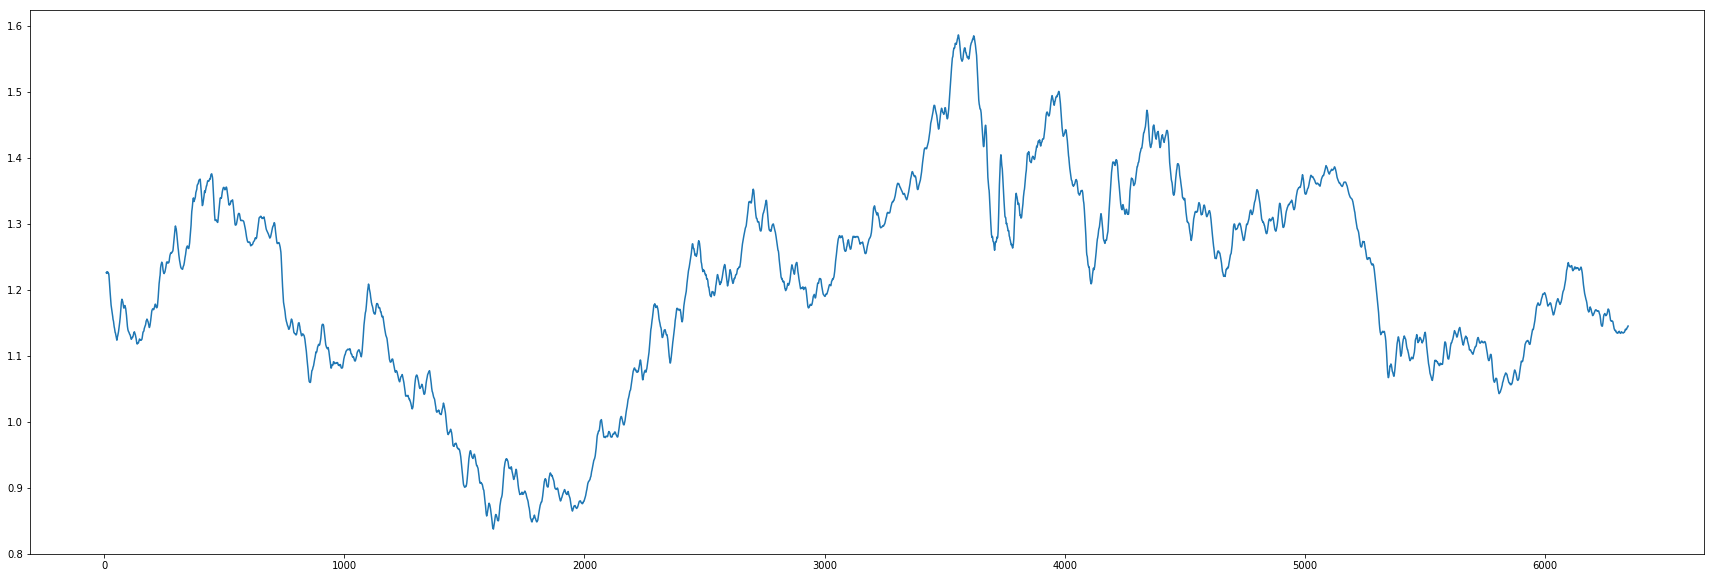

In [34]:
plt.figure(figsize=(30,10))
# plt.plot(hund['Close'])

# plt.figure(figsize=(30,10))
plt.plot(target['Close'].rolling(window=10).mean())


# As we can see, our training set comprises of all the years except 2018. All our testing is done on 2018, which is an unseen year for our model, still it performs very well

In [35]:
columns=['Month','Year',
       'Moon_right asc.', 'Moon_declination', 'Moon_distance',
       'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance',
       'Venus_right asc.', 'Venus_declination', 'Venus_distance',
       'Mars_right asc.', 'Mars_declination', 'Mars_distance',
       'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance',
       'Saturn_right asc.', 'Saturn_declination', 'Saturn_distance',
       'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance',
       'Neptune_right asc.', 'Neptune_declination', 'Neptune_distance',
       'Earth_right asc.', 'Earth_declination', 'Earth_distance']

new_columns=['new'+i for i in columns]

In [36]:
def normalize(*df):
    dfs=list(df)
    min_max_scaler =MinMaxScaler()
    column=['Month','Year',
       'Moon_right asc.', 'Moon_declination', 'Moon_distance',
       'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance',
       'Venus_right asc.', 'Venus_declination', 'Venus_distance',
       'Mars_right asc.', 'Mars_declination', 'Mars_distance',
       'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance',
       'Saturn_right asc.', 'Saturn_declination', 'Saturn_distance',
       'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance',
       'Neptune_right asc.', 'Neptune_declination', 'Neptune_distance',
       'Earth_right asc.', 'Earth_declination', 'Earth_distance']
    
    for i in column:
        for j in range(len(dfs)):      
            if j==0:
                dfs[j]['new'+i] = min_max_scaler.fit_transform(np.array(dfs[j][i]).reshape(-1,1))
            else:
                dfs[j]['new'+i] = min_max_scaler.transform(np.array(dfs[j][i]).reshape(-1,1))
    return dfs


In [37]:
feat_columns = features_csv.columns
feat_columns

Index(['Earth_declination', 'Earth_distance', 'Earth_right asc.',
       'Jupiter_declination', 'Jupiter_distance', 'Jupiter_right asc.',
       'Mars_declination', 'Mars_distance', 'Mars_right asc.',
       'Mercury_declination', 'Mercury_distance', 'Mercury_right asc.',
       'Month', 'Moon_declination', 'Moon_distance', 'Moon_right asc.',
       'Neptune_declination', 'Neptune_distance', 'Neptune_right asc.',
       'Saturn_declination', 'Saturn_distance', 'Saturn_right asc.',
       'Uranus_declination', 'Uranus_distance', 'Uranus_right asc.',
       'Venus_declination', 'Venus_distance', 'Venus_right asc.', 'Year'],
      dtype='object')

In [38]:
x=normalize(features, myresult)
features = x[0]
myresult = x[1]

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
predict=pd.concat([features[new_columns],  myresult[new_columns]],axis=0)
predict.reset_index(inplace=True)
predict.drop(['index'],axis=1,inplace=True)
final_date = pd.concat([feature_date, myresult_date], axis = 0)

predict_csv=pd.concat([features[columns],  myresult[columns]],axis=0)
predict_csv.reset_index(inplace=True)
predict_csv.drop(['index'],axis=1,inplace=True)


# for_vis=pd.concat([features[columns],myresult[columns]],axis=0)
# for_vis[:-13].to_csv('predict.csv')

# Place below the number of In-Sample examples

In [40]:
total_no_of_examples_with_close_price = features.shape[0]
total_no_of_examples_with_close_price

6347

In [41]:
train_percent = 50 #Mention the percent of data you wanna use for training
train_percent = train_percent/100.0

In [42]:
no_of_sample_you_wanna_train_with = math.floor(train_percent * total_no_of_examples_with_close_price)
print("So the number of examples used for training algorithm will be: ", no_of_sample_you_wanna_train_with)

trainx=features[new_columns][0:no_of_sample_you_wanna_train_with]
trainy=target[0:no_of_sample_you_wanna_train_with]
testx=features[new_columns][no_of_sample_you_wanna_train_with:] #All the remaining examples will be used as test 
testy=target[no_of_sample_you_wanna_train_with:]

So the number of examples used for training algorithm will be:  3173


In [43]:
features=np.array(features[new_columns])
predict=np.array(predict)
final_date = np.array(final_date)
feature_date = np.array(feature_date)
trainx=np.array(trainx)
trainy=np.array(trainy)
testx=np.array(testx)
testy=np.array(testy)
target=np.array(target)

In [44]:
no_features=29
timesteps=30

def modify_output(x):
    net_shape=x.size/no_features
    floor_shape=math.floor(net_shape/timesteps)
    tobe=floor_shape*timesteps
    net_shape=net_shape-tobe
    return x[0:-int(net_shape)].reshape(-1,timesteps,no_features),int(net_shape)

In [45]:
trainx,tr=modify_output(trainx)
trainy=trainy[0: -tr].reshape((trainx.shape[0],-1))
testx,te=modify_output(testx)
testy=testy[0: -te].reshape((testx.shape[0],-1))
features,fe=modify_output(features)
target=target[0: -fe].reshape((features.shape[0],-1))
feature_date = feature_date[0: -fe].reshape(features.shape[0], -1)
predict,pr=modify_output(predict)
final_date = final_date[0: -pr].reshape((predict.shape[0], -1))


## Using LSTM Model

Best combination so far is of 5 units in first layer and four units in second layer.

In [46]:
model=Sequential()
model.add(LSTM(units=15,input_shape=(timesteps,no_features),return_sequences=True))
model.add(LSTM(10,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(trainx.shape[1])) 
ad = Adam(lr=0.01, clipnorm=1)
             
model.compile(loss="mae", optimizer=ad) 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 30, 15)            2700      
_________________________________________________________________
lstm_2 (LSTM)                (None, 10)                1040      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 30)                330       
Total params: 4,070
Trainable params: 4,070
Non-trainable params: 0
_________________________________________________________________


In [47]:
model.load_weights('model.h5')
history = model.fit(trainx, trainy, epochs=1,batch_size=1000, validation_data=(testx, testy), verbose=1, shuffle=False)
#If you wanna train, change epoch from 1 to 500. Remember, also more the number of epoch, more you train, so chances are that you'll overfit, so try for 300-500 epoch. 
#Sometimes you might have to train for even 1000 epoch, depending on data.

Train on 105 samples, validate on 105 samples
Epoch 1/1
105/105 [==============================] - 1s 10ms/step - loss: 0.0370 - val_loss: 0.0892


In [48]:
#DO NOT CHANGE PARAMETERS OF THIS CELL

inputt=Input(shape=(timesteps,no_features))
bi_one=Bidirectional(LSTM(10, return_sequences=True,activation='linear'))(inputt)
bi_sec=Bidirectional(LSTM(15, return_sequences=False,activation='linear'))(bi_one)
output=Dense(trainx.shape[1], activation='linear')(bi_sec)             

model1 = keras.models.Model(inputt,output)

ad = Adam(lr=0.01, clipnorm=1)

             
model1.compile(loss="mae", optimizer=ad) 
model1.summary()

history = model1.fit(features, target, epochs=1,batch_size=1000, validation_data=(testx, testy), verbose=1, shuffle=False)
model1.load_weights('model1.h5')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 29)            0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 30, 20)            3200      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 30)                4320      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                930       
Total params: 8,450
Trainable params: 8,450
Non-trainable params: 0
_________________________________________________________________
Train on 211 samples, validate on 105 samples
Epoch 1/1
211/211 [==============================] - 2s 11ms/step - loss: 3.9715 - val_loss: 1.2409


In [49]:
feature_ans=model.predict(features)
feature_ans=feature_ans.reshape((-1,1))
feature_ans1=model1.predict(features)
feature_ans1=feature_ans1.reshape((-1,1))

beta=0.9


for i in range(feature_ans.shape[0]):
    
    if i==0:
        feature_ans[i]=beta*target[-1][-1]+(1-beta)*feature_ans[i]
    else:
        feature_ans[i]=beta*feature_ans[i-1]+(1-beta)*(0.75 *feature_ans[i] + 0.25*feature_ans1[i])
        
feature_ans=pd.DataFrame(feature_ans,columns=['hel'])


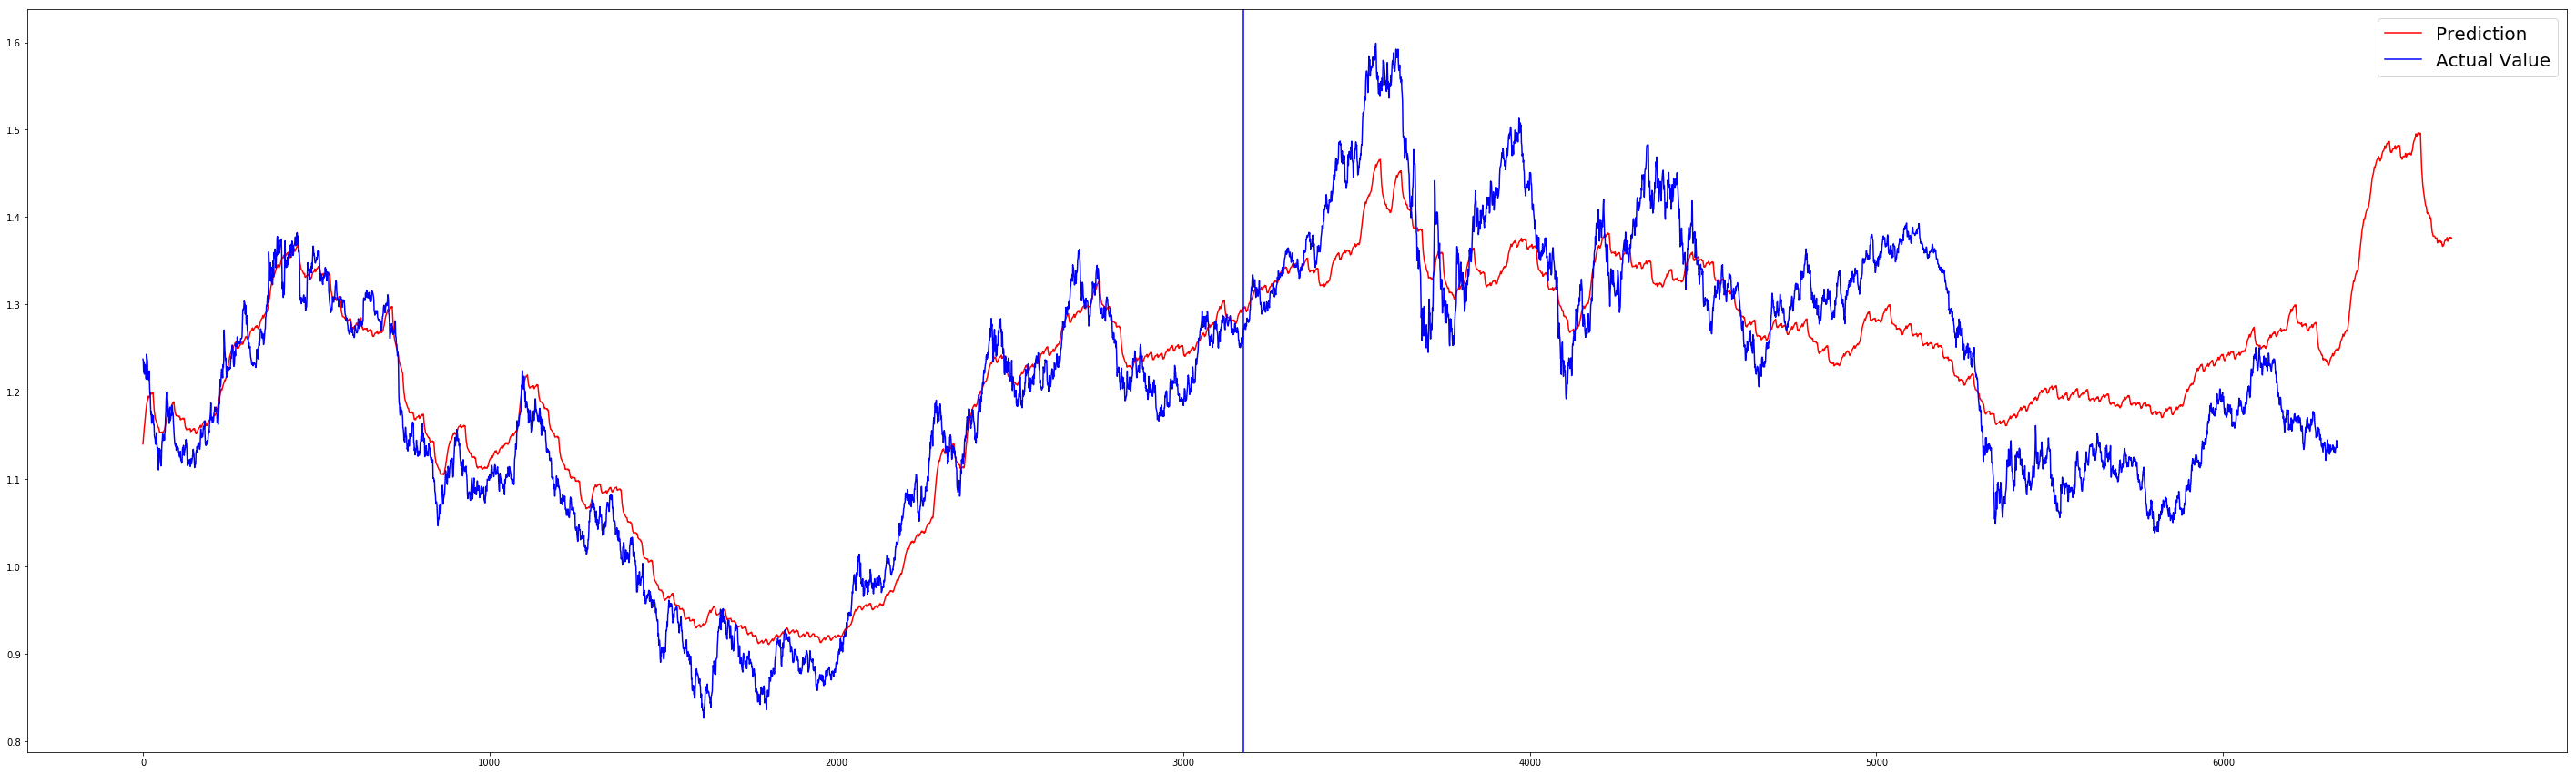

In [50]:
ans=model.predict(predict)
ans=ans.reshape((-1,1))
ans1=model1.predict(predict)
ans1=ans1.reshape((-1,1))

beta=0.9


for i in range(ans.shape[0]):
    
    if i==0:
        ans[i]=beta*target[-1][-1]+(1-beta)*ans[i]
    else:
        ans[i]=beta*ans[i-1]+(1-beta)*(0.75 *ans[i] + 0.25*ans1[i])
        

ans=pd.DataFrame(ans,columns=['hel'])
plt.figure(figsize=(50,15))
plt.plot(ans['hel'],color='red',label='Prediction')
plt.axvline(no_of_sample_you_wanna_train_with,color='blue')

plt.plot(target.reshape((-1,1)),color='blue',label='Actual Value')
plt.legend( prop={'size': 20})

# If you want to save weight, remove # before model.save, it'll save weight, NOTE: It'll overwrite previous weight, so make a copy 

In [51]:
#model.save_weights('model.h5')
predict_csv = np.array(predict_csv)
predict_csv,_ = modify_output(predict_csv)
predict_csv = np.reshape(predict_csv, (-1, 29))
predict_csv = pd.DataFrame(predict_csv)

In [52]:
predict_csv.columns = columns
predict_csv.drop([ 'Moon_right asc.', 'Moon_declination', 'Moon_distance', 'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance', 'Venus_right asc.', 'Venus_declination',
 'Venus_distance', 'Mars_right asc.', 'Mars_declination', 'Mars_distance', 'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance', 'Saturn_right asc.',
 'Saturn_declination', 'Saturn_distance', 'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance', 'Neptune_right asc.', 'Neptune_declination',
 'Neptune_distance', 'Earth_right asc.', 'Earth_declination', 'Earth_distance'], axis = 1, inplace = True)

In [53]:
features_csv = np.array(features_csv)
features_csv, _ = modify_output(features_csv)
features_csv = np.reshape(features_csv, (-1, 29))
features_csv = pd.DataFrame(features_csv)
features_csv.columns = feat_columns
features_csv.drop(['Moon_right asc.', 'Moon_declination', 'Moon_distance', 'Mercury_right asc.', 'Mercury_declination', 'Mercury_distance', 'Venus_right asc.', 'Venus_declination',
 'Venus_distance', 'Mars_right asc.', 'Mars_declination', 'Mars_distance', 'Jupiter_right asc.', 'Jupiter_declination', 'Jupiter_distance', 'Saturn_right asc.',
 'Saturn_declination', 'Saturn_distance', 'Uranus_right asc.', 'Uranus_declination', 'Uranus_distance', 'Neptune_right asc.', 'Neptune_declination',
 'Neptune_distance', 'Earth_right asc.', 'Earth_declination', 'Earth_distance'], axis = 1, inplace = True)
feature_date = feature_date.reshape(-1)

features_csv['Day'] = feature_date


In [54]:
final_date = final_date.reshape(-1,)
predict_csv['Day'] = final_date

In [55]:
features_csv.head()

Month    Year  Day
0    5.0  1993.0   11
1    5.0  1993.0   12
2    5.0  1993.0   13
3    5.0  1993.0   14
4    5.0  1993.0   18

In [57]:
with_price = pd.concat([features_csv, feature_ans], axis = 1)
final_result = pd.concat([predict_csv, ans], axis = 1)

In [59]:
final_result.columns = ['Month', 'Year','Day','Predicted']
with_price.columns = ['Month', 'Year','Day','Predicted']


In [60]:
final_result.to_csv('predicted_close.csv')
with_price.to_csv('with_actual_and_predictec_price.csv')

In [61]:
with_price.head()

Month    Year  Day  Predicted
0    5.0  1993.0   11   1.140451
1    5.0  1993.0   12   1.145292
2    5.0  1993.0   13   1.149320
3    5.0  1993.0   14   1.153919
4    5.0  1993.0   18   1.159588

In [62]:
final_result.head()

Month    Year  Day  Predicted
0    5.0  1993.0   11   1.140451
1    5.0  1993.0   12   1.145292
2    5.0  1993.0   13   1.149320
3    5.0  1993.0   14   1.153919
4    5.0  1993.0   18   1.159588